# MRSA RNA-seq project - determining adequate read depth
Rasmus Ågren, 171205

We are trying to determine adequate sequencing depth for future RNA-seq experiments. I have been concerned that 25000 reads per sample may not be enough to capture lowly expressed genes. Here I plan to rerun the Snakemake workflow with different settings to investigate this.

First install the packages in `environment.yml` into my current environment.

In [1]:
%%capture output
%%bash
conda env update -f environment.yml

In [4]:
output.stderr

''

No error, that seemed to work.

A dry-run to ensure that everything looks fine. I'm only interested in `counts.tsv`.

In [5]:
!snakemake --configfile config.yml results/tables/counts.tsv -n

Building DAG of jobs...

rule get_genome_fasta:
    output: data/raw_external/NCTC8325.fa.gz
    log: results/logs/get_genome_fasta/NCTC8325.log
    jobid: 12
    wildcards: genome_id=NCTC8325


rule index_genome:
    input: data/raw_external/NCTC8325.fa.gz
    output: intermediate/NCTC8325.1.bt2, intermediate/NCTC8325.2.bt2, intermediate/NCTC8325.3.bt2, intermediate/NCTC8325.4.bt2, intermediate/NCTC8325.rev.1.bt2, intermediate/NCTC8325.rev.2.bt2
    log: results/logs/index_genome/NCTC8325.log
    jobid: 8
    wildcards: genome_id=NCTC8325


rule get_SRA_by_accession:
    output: data/raw_internal/SRR935090.fastq.gz
    jobid: 11
    wildcards: sra_id=SRR935090


rule get_SRA_by_accession:
    output: data/raw_internal/SRR935091.fastq.gz
    jobid: 9
    wildcards: sra_id=SRR935091


rule get_SRA_by_accession:
    output: data/raw_internal/SRR935092.fastq.gz
    jobid: 10
    wildcards: sra_id=SRR935092


rule align_to_genome:
    input: data/raw_internal/SRR935090.fastq.gz, intermedia

Looks good, then run with the default number of reads (25000).

In [6]:
!snakemake --configfile config.yml results/tables/counts.tsv

Building DAG of jobs...
Provided cores: 1
Rules claiming more threads will be scaled down.
Job counts:
	count	jobs
	3	align_to_genome
	1	generate_count_table
	3	get_SRA_by_accession
	1	get_genome_fasta
	1	get_genome_gff3
	1	index_genome
	3	sort_bam
	13

rule get_genome_fasta:
    output: data/raw_external/NCTC8325.fa.gz
    log: results/logs/get_genome_fasta/NCTC8325.log
    jobid: 12
    wildcards: genome_id=NCTC8325

Finished job 12.
1 of 13 steps (8%) done

rule index_genome:
    input: data/raw_external/NCTC8325.fa.gz
    output: intermediate/NCTC8325.1.bt2, intermediate/NCTC8325.2.bt2, intermediate/NCTC8325.3.bt2, intermediate/NCTC8325.4.bt2, intermediate/NCTC8325.rev.1.bt2, intermediate/NCTC8325.rev.2.bt2
    log: results/logs/index_genome/NCTC8325.log
    jobid: 8
    wildcards: genome_id=NCTC8325

Building a SMALL index
Finished job 8.
2 of 13 steps (15%) done

rule get_SRA_by_accession:
    output: data/raw_internal/SRR935091.fastq.gz
    jobid: 9
    wildcards: sra_id=SRR9350

Import the count table and count the proportion of genes without any genes mapping to them.

In [7]:
import pandas as pd
df = pd.read_csv('results/tables/counts.tsv', sep='\t')

# Print summary
df

,,intermediate/SRR935090.sorted.bam,intermediate/SRR935091.sorted.bam,intermediate/SRR935092.sorted.bam
EBG00001047198,NaN,82,92,98
EBG00001047212,NaN,1,0,0
EBG00001047229,NaN,0,0,0
EBG00001047235,NaN,0,0,0
EBG00001047237,NaN,0,0,0
EBG00001047248,NaN,0,0,0
EBG00001047250,NaN,0,0,0
EBG00001047252,NaN,0,1,0
EBG00001047255,NaN,0,0,0
EBG00001047260,NaN,0,0,0


Ok, doesn't look great. The number of unaligned genes is much higher in SRR935091 than in the other samples (see last rows), and the majority of the genes seem to have zero hits. The fraction of mapping reads is also low.

Here is a small utility function for returning the fraction of genes with zero reads mapping.

In [8]:
def fraction_no_hits(df):
    """Takes a pandas data frame and returns the fraction
    of rows that contain 0 for each column.
    """
    return (df == 0).astype(int).sum(axis=0)/float(df.shape[0])

In [9]:
fraction_no_hits(df)

intermediate/SRR935090.sorted.bam    0.580634
intermediate/SRR935091.sorted.bam    0.675077
intermediate/SRR935092.sorted.bam    0.502216
dtype: float64

That looked better than I thought. Seems like the rows in the summary weren't representative. I try with 50000 reads to see if there is a significant increase, otherwise I stick to 25000. 

In [10]:
!snakemake --configfile config.yml results/tables/counts.tsv -R get_SRA_by_accession --config max_reads=50000

Building DAG of jobs...
Provided cores: 1
Rules claiming more threads will be scaled down.
Job counts:
	count	jobs
	3	align_to_genome
	1	generate_count_table
	3	get_SRA_by_accession
	3	sort_bam
	10

rule get_SRA_by_accession:
    output: data/raw_internal/SRR935091.fastq.gz
    jobid: 8
    wildcards: sra_id=SRR935091

Read 50000 spots for SRR935091
Written 50000 spots for SRR935091
Finished job 8.
1 of 10 steps (10%) done

rule get_SRA_by_accession:
    output: data/raw_internal/SRR935092.fastq.gz
    jobid: 11
    wildcards: sra_id=SRR935092

Read 50000 spots for SRR935092
Written 50000 spots for SRR935092
Finished job 11.
2 of 10 steps (20%) done

rule get_SRA_by_accession:
    output: data/raw_internal/SRR935090.fastq.gz
    jobid: 10
    wildcards: sra_id=SRR935090

Read 50000 spots for SRR935090
Written 50000 spots for SRR935090
Finished job 10.
3 of 10 steps (30%) done

rule align_to_genome:
    input: data/raw_internal/SRR935090.fastq.gz, intermediate/NCTC8325.1.bt2, intermedia

In [12]:
df_50000 = pd.read_csv('results/tables/counts.tsv', sep='\t')
fraction_no_hits(df_50000)

intermediate/SRR935090.sorted.bam    0.470849
intermediate/SRR935091.sorted.bam    0.556768
intermediate/SRR935092.sorted.bam    0.392772
dtype: float64

Ok, that gave about a 10% decrease. That is probably not enough to justify the higher cost of generating twice the number of reads.

Here is a histogram over the number of mapping reads for each of the samples.

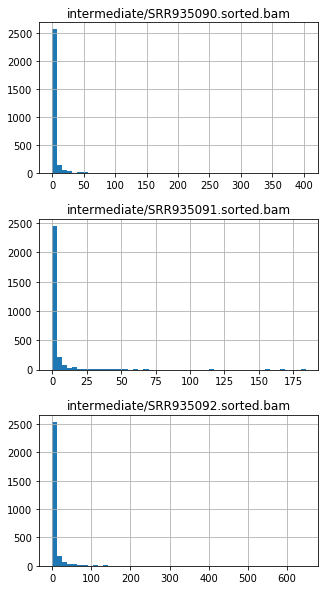

In [23]:
%matplotlib inline
# Discard the last 5 lines since the aren't for genes
df_50000 = df_50000.drop(df_50000.tail(5).index)
df_50000.hist(bins = 50, layout = (3,1), figsize = (5,10));

Well, seems like the vast majority of the genes have very few reads mapping. I may have to look into this further after all.

TODO: Investigate sequencing cost if using 50000 reads per sample.